# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lecture 33 Notebook: Training a FFN 

**Harvard University**<br>
**Fall 2020**<br>
**Instructors:** Pavlos Protopapas, Kevin Rader, Chris Tanner<br>
**Authors:** Eleni Kaxiras, David Sondak, and Pavlos Protopapas. 

In [17]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT CELLS
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import StandardScaler
%matplotlib inline

from PIL import Image, ImageOps

In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

print(tf.__version__)  # You should see a 2.0.0 here!

2.0.0


In [20]:
# set the seed for reproducability
seed = 7
np.random.seed(seed)

### Tensorflow 2.0:  

All references to Keras should be written as `tf.keras`.  For example: 

```
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
tf.keras.models.Sequential
tf.keras.layers.Dense, tf.keras.layers.Activation, 
tf.keras.layers.Dropout, tf.keras.layers.Flatten, tf.keras.layers.Reshape
tf.keras.optimizers.SGD
tf.keras.preprocessing.image.ImageDataGenerator
tf.keras.regularizers
tf.keras.datasets.mnist   
```

You could avoid the long names by using
```
from tensorflow import keras
from tensorflow.keras import layers
```
These imports do not work on some systems, however, because they pick up previous versions of `keras` and `tensorflow`. 

### Tensors

We can think of tensors as multidimensional arrays of real numerical values; their job is to generalize matrices to multiple dimensions. 

- **scalar** = just a number = rank 0 tensor  ($a$ ∈ $F$,)
<BR><BR>
    
- **vector** = 1D array = rank 1 tensor ( $x = (\;x_1,...,x_i\;)⊤$ ∈ $F^n$ )
<BR><BR>
    
- **matrix** = 2D array = rank 2 tensor ( $\textbf{X} = [a_{ij}] ∈ F^{m×n}$ )
<BR><BR>
    
- **3D array** = rank 3 tensor ( $\mathscr{X} =[t_{i,j,k}]∈F^{m×n×l}$ )
<BR><BR>
    

### First you build the network

- **The input layer**: our dataset.
- **The internal architecture or hidden layers** the number of layers, the activation functions, the learnable parameters and other hyperparameters)
- **The output layer**: what we want from the network, a probability for belonging in a class (classification) or a number (regression).

1. Load and pre-process the data
2. Define the layers of the model.
3. Compile the model.

### ... and then you train it!

4. Fit the model to the train set (also using a validation set). Save the model.
5. Evaluate the model on the test set.
6. We learn a lot by studying history: metric traceplots. 
7. Regularize the model.
8. Now let's use the Network to predict on the test set.
9. Try our model on a sandal from the Kanye West collection!

### 1. Load the data

### Fashion MNIST 

**Fashion-MNIST** is a dataset of clothing article images (created by [Zalando](https://github.com/zalandoresearch/fashion-mnist)), consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a **28 x 28** grayscale image, associated with a label from **10 classes**. The creators intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. Each pixel is 8 bits so its value ranges from 0 to 255. These images do not have a `channel` dimension because they are B&W.

Let's load and look at it!

In [86]:
# get the data from keras
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data splitted in train and test! 
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()

print(x_train.shape, y_train.shape, '\n\n', x_train[56][:2], '\n\n', set(y_train))

(60000, 28, 28) (60000,) 

 [[  0   0   0   0   1   0   0   0   0   0   0 152 192 135 134 165 209  25
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  68 178 253 230 234 243 244 231 223 254
  207  92   0   0   0   0   0   0   0   0]] 

 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [22]:
# checking the min and max of x_train and x_test
print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

0 255 0 255


In [23]:
# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
x_train, x_test = x_train / 255.0, x_test / 255.0

print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

0.0 1.0 0.0 1.0


In [24]:
# inspect a single image array
print(x_train[45].shape)
print(x_train[45][:2][:2])

(28, 28)
[[0.         0.         0.         0.00392157 0.         0.
  0.         0.         0.         0.13333333 0.58039216 0.79215686
  0.41960784 0.32941176 0.63529412 0.77647059 0.35294118 0.10196078
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.08235294 0.41960784 0.65098039 0.65882353 0.59607843 0.8
  0.93333333 0.97254902 0.92941176 0.74509804 0.55686275 0.69803922
  0.61960784 0.38431373 0.06666667 0.         0.         0.
  0.         0.         0.         0.        ]]


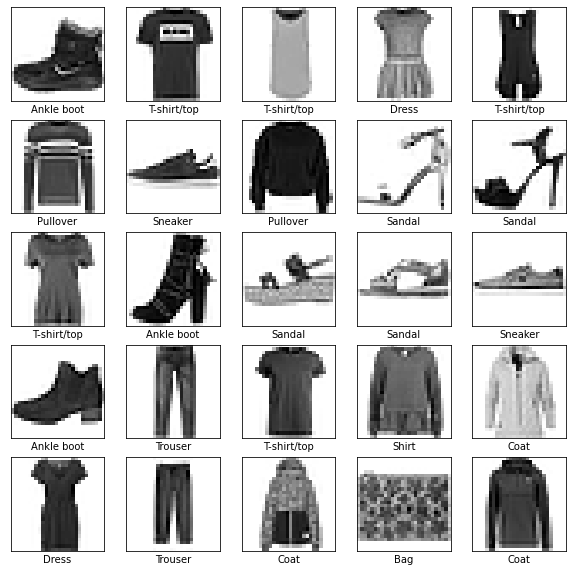

In [25]:
# Give names to classes for clarity
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# plot
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

### 2. Define the layers of the model.

In [26]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(154, activation='relu'))
model.add(tf.keras.layers.Dense(154, activation='relu'))
model.add(tf.keras.layers.Dense(154, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

### 3. Compile the model

In [28]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 154)               120890    
_________________________________________________________________
dense_1 (Dense)              (None, 154)               23870     
_________________________________________________________________
dense_2 (Dense)              (None, 154)               23870     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                9920      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 179,200
Trainable params: 179,200
Non-trainable params: 0
__________________________________________________

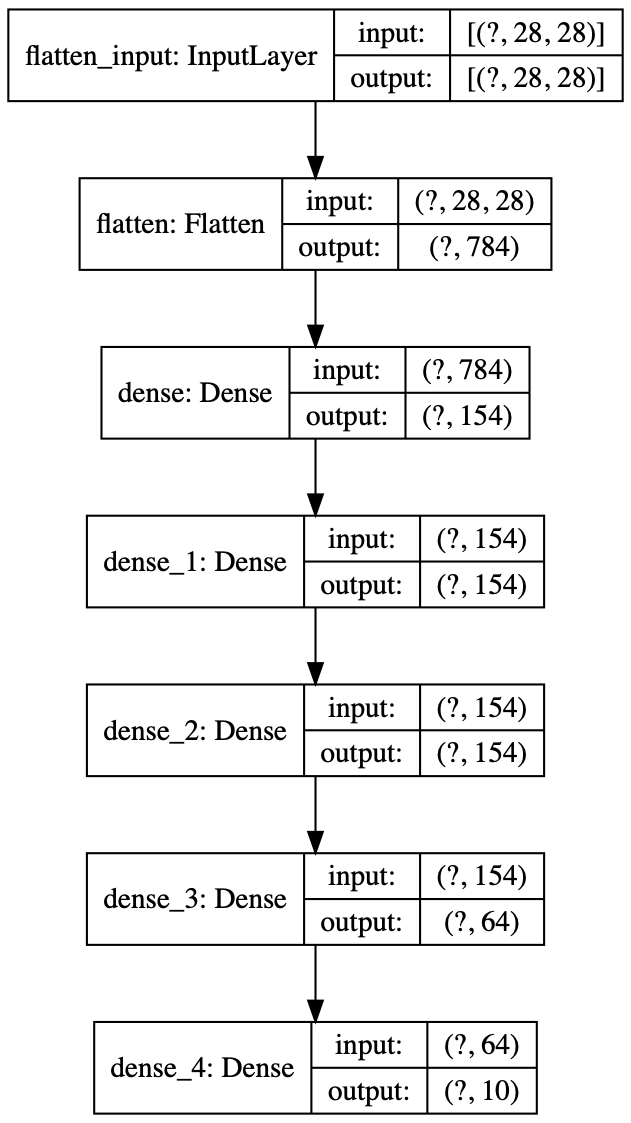

In [30]:
tf.keras.utils.plot_model(
    model,
    #to_file='model.png', # if you want to save the image
    show_shapes=True, # True to see more details 
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=150
)

[Everything you wanted to know about a Keras Model and were afraid to ask](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

### 4. Fit the model to the train set (also using a validation set)

This is the part that takes the longest.

-----------------------------------------------------------
**ep·och** <BR>
noun: epoch; plural noun: epochs. A period of time in history or a person's life, typically one marked by notable events or particular characteristics. Examples: "the Victorian epoch", "my Neural Netwok's epochs". <BR>
    
-----------------------------------------------------------

In [31]:
%%time
# Fit the model <--- always a good idea to time it! 

history = model.fit(x_train, y_train, validation_split=0.33, epochs=50, 
                    verbose=2)

Train on 40199 samples, validate on 19801 samples
Epoch 1/50
40199/40199 - 10s - loss: 0.5395 - accuracy: 0.8052 - val_loss: 0.4072 - val_accuracy: 0.8530
Epoch 2/50
40199/40199 - 10s - loss: 0.3894 - accuracy: 0.8593 - val_loss: 0.3931 - val_accuracy: 0.8596
Epoch 3/50
40199/40199 - 11s - loss: 0.3483 - accuracy: 0.8709 - val_loss: 0.3556 - val_accuracy: 0.8706
Epoch 4/50
40199/40199 - 11s - loss: 0.3260 - accuracy: 0.8798 - val_loss: 0.3400 - val_accuracy: 0.8767
Epoch 5/50
40199/40199 - 10s - loss: 0.3089 - accuracy: 0.8853 - val_loss: 0.3654 - val_accuracy: 0.8718
Epoch 6/50
40199/40199 - 10s - loss: 0.2904 - accuracy: 0.8919 - val_loss: 0.3781 - val_accuracy: 0.8647
Epoch 7/50
40199/40199 - 11s - loss: 0.2792 - accuracy: 0.8946 - val_loss: 0.3177 - val_accuracy: 0.8836
Epoch 8/50
40199/40199 - 10s - loss: 0.2676 - accuracy: 0.8994 - val_loss: 0.3233 - val_accuracy: 0.8830
Epoch 9/50
40199/40199 - 10s - loss: 0.2600 - accuracy: 0.9024 - val_loss: 0.3434 - val_accuracy: 0.8786
Epoch

#### Save the model

You can save the model so you do not have `.fit` everytime you reset the kernel in the notebook. Network training is expensive!

For more details on this see [https://www.tensorflow.org/guide/keras/save_and_serialize](https://www.tensorflow.org/guide/keras/save_and_serialize)

In [ ]:
# save the model so you do not have to run the code everytime
model.save('fashion_model.h5')

# Recreate the exact same model purely from the file
#model = tf.keras.models.load_model('fashion_model.h5')

### 5. Evaluate the model on the test set.

In [32]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy={test_accuracy}')

Test accuracy=0.8830999732017517


### 6. We learn a lot by studying history: metric traceplots. 

You can learn a lot about neural networks by observing how they perform while training. The networks's performance is stored in a variable named `history` which can be plotted. 

In [33]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


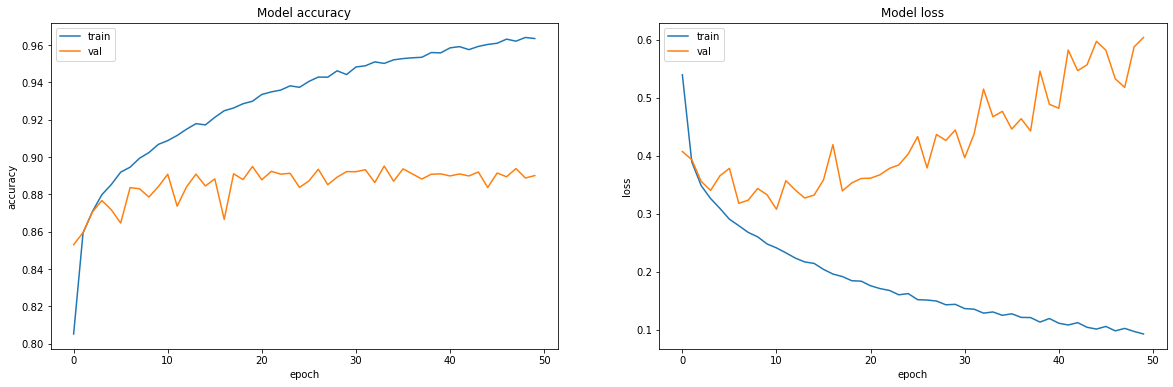

In [34]:
# plot accuracy and loss for the test set
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='best')

<div class="exercise"><b>What do you observe in these traceplots?</b></div>

### 7. Regularization
Let's try adding a regularizer in our model. For more see `tf.keras` [regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers).<BR>

1. Norm penalties: `kernel_regularizer= tf.keras.regularizers.l2(l=0.1)`
2. Early stopping via `tf.keras.callbacks`. Callbacks provide a way to interact with the model while it's training and inforce some decisions automatically. Callbacks need to be instantiated and are added to the `.fit()` function via the `callbacks` argument.
3. Dropout

In [73]:
model_regular = tf.keras.models.Sequential()
model_regular.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model_regular.add(tf.keras.layers.Dense(154, activation='relu'))
model_regular.add(tf.keras.layers.Dense(64, activation='relu'))
model_regular.add(tf.keras.layers.Dropout(0.2))
model_regular.add(tf.keras.layers.Dense(10, activation='softmax'))

In [74]:
# alternative ways of regularizing
# model_regular = tf.keras.Sequential()
# model_regular.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
# model_regular.add(tf.keras.layers.Dense(154, activation='relu', 
#                                         kernel_regularizer= tf.keras.regularizers.l2(l=0.001)))
# model_regular.add(tf.keras.layers.Dense(64, activation='relu',
#                                         kernel_regularizer= tf.keras.regularizers.l2(l=0.001)))
# model_regular.add(tf.keras.layers.Dropout(0.2))
# model_regular.add(tf.keras.layers.Dense(10, activation='softmax'))

In [75]:
# callbacks: watch validation loss and be "patient" for 10 epochs of no improvement
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=20) 

# compile
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model_regular.compile(optimizer=optimizer,
                      loss=loss_fn,
                      metrics=['accuracy'])

In [76]:
%%time
# fit
history_regular = model_regular.fit(x_train, y_train, validation_split=0.2, epochs=50, 
                                    verbose=1, callbacks=[es])

Train on 36000 samples, validate on 24000 samples
Epoch 1/50
36000/36000 [==============================] - 9s 241us/sample - loss: 0.5889 - accuracy: 0.7911 - val_loss: 0.4167 - val_accuracy: 0.8482
Epoch 2/50
36000/36000 [==============================] - 8s 230us/sample - loss: 0.4155 - accuracy: 0.8476 - val_loss: 0.3776 - val_accuracy: 0.8643
Epoch 3/50
36000/36000 [==============================] - 9s 242us/sample - loss: 0.3746 - accuracy: 0.8612 - val_loss: 0.3635 - val_accuracy: 0.8695
Epoch 4/50
36000/36000 [==============================] - 9s 246us/sample - loss: 0.3483 - accuracy: 0.8726 - val_loss: 0.3731 - val_accuracy: 0.8646
Epoch 5/50
36000/36000 [==============================] - 9s 245us/sample - loss: 0.3266 - accuracy: 0.8783 - val_loss: 0.3569 - val_accuracy: 0.8722
Epoch 6/50
36000/36000 [==============================] - 9s 252us/sample - loss: 0.3097 - accuracy: 0.8842 - val_loss: 0.3621 - val_accuracy: 0.8720
Epoch 7/50
36000/36000 [==========================

In [77]:
test_loss_regular, test_accuracy_regular = model_regular.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy:\nBaseline model={test_accuracy:.4f}\nRegularized model={test_accuracy_regular:.4f}')

Test accuracy:
Baseline model=0.8831
Regularized model=0.8823


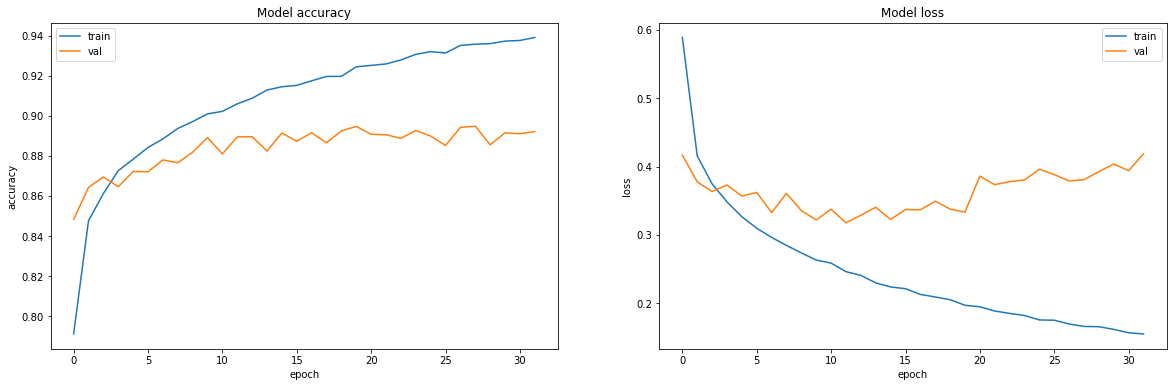

In [78]:
# plot accuracy and loss for the test set
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(history_regular.history['accuracy'])
ax[0].plot(history_regular.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(history_regular.history['loss'])
ax[1].plot(history_regular.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='best')

#### Conclusion

We notice that Dropout helped our first model achive a 0.88 accuracy. In our second model which also used L2 regularization, we get a lower accuracy. There is no simple recipe for regularizing neural nets. They are all different.  Different are also the tasks that each is called to solve.

### 7. Now let's predict in the test set

In [99]:
predictions = model_regular.predict(x_test)

In [134]:
# choose a specific item to predict
item = 6000

In [135]:
predictions[item]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [136]:
np.argmax(predictions[item]), class_names[np.argmax(predictions[item])]

(1, 'Trouser')

Let's see if our network predicted right! Is the first item what was predicted?

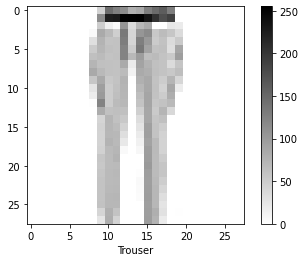

In [137]:
plt.figure()
plt.imshow(x_test[item], cmap=plt.cm.binary)
plt.xlabel(class_names[y_test[item]])
plt.colorbar()

In [104]:
# code source: https://www.tensorflow.org/tutorials/keras/classification
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

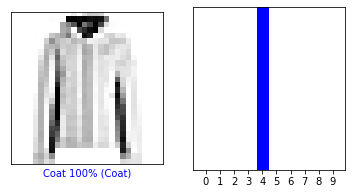

In [105]:
i = item
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

### 8. Try our model on a sandal from the Kanye West collection!
The true usefullness of a NN is to be able to classigy unseen data and not only on the test set. Let's see if our network can generalize beyond the MNIST fashion dataset. Let's give it a trendy shoe and see what it predicts. This image is not part of the test set, it was downloaded from the internet. 

<img src="kanye_shoe.jpg" alt="shoe" width="150" height="150"><BR>
<div class="exercise"><b>In class discussion : What kinds of images can our model predict?</b></div>

Bias measures how much the network's output, averaged over all possible data sets differs from the true function. Variance measures how much the network output varies between datasets. 

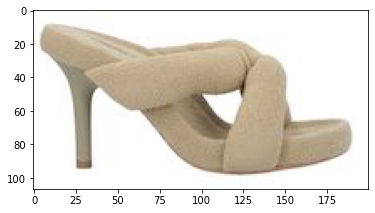

In [138]:
# Let'see the tensor shape
shoe = Image.open('kanye_shoe.jpg')
imgplot = plt.imshow(shoe)

#### Pre-processing

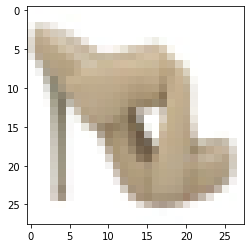

In [107]:
# Resize image to 28x28
shoe = shoe.resize((28, 28))
imgplot = plt.imshow(shoe)

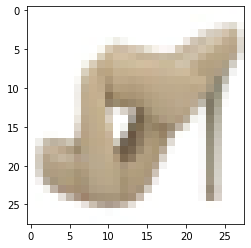

In [108]:
shoe = ImageOps.mirror(shoe)
imgplot = plt.imshow(shoe)

(28, 28)


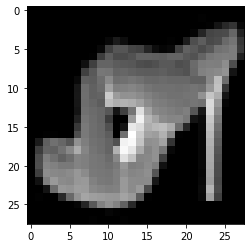

In [116]:
# Delete the other 2 channels to make image B&W. 
shoe_data = np.array(shoe) # cast into munpy array
shoe_data = shoe_data[:,:,0]
print(shoe_data.shape)
imgplot = plt.imshow(shoe_data, cmap=plt.cm.binary)

`tf.keras` models are optimized to make predictions on a batch, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [117]:
# Add the image to a batch where it's the only member.
shoe_batch = (np.expand_dims(shoe_data,0))
print(shoe_batch.shape)

(1, 28, 28)


In [118]:
predictions_single = model_regular.predict(shoe_batch)
print(predictions_single[0])
print(np.argmax(predictions_single[0]), class_names[np.argmax(predictions_single[0])])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
8 Bag


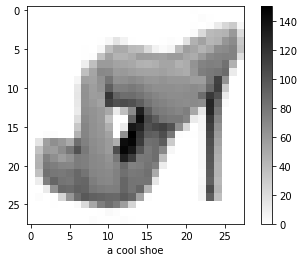

In [119]:
shoe_data = np.ones(shoe_data.shape) * 255 - shoe_data
plt.figure()
plt.imshow(shoe_data, cmap=plt.cm.binary)
plt.xlabel('a cool shoe')
plt.colorbar()

In [120]:
# Add the image to a batch where it's the only member.
shoe_batch = (np.expand_dims(shoe_data,0))
print(shoe_batch.shape)

(1, 28, 28)


In [123]:
predictions_single = model_regular.predict(shoe_batch)
print(predictions_single[0])
print(np.argmax(predictions_single[0]), class_names[np.argmax(predictions_single[0])])

[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 9.767409e-18]
5 Sandal


### Data augementation

Data augmentation generates more training data by applying a series of random transformations that yield belivable images. Be careful of transformations that result in unlikely images.

In [130]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [131]:
shoe_augm = (np.expand_dims(shoe_data,0))
shoe_augm = (np.expand_dims(shoe_augm, 3))
print(shoe_augm.shape)

(1, 28, 28, 1)


In [132]:
img = shoe_augm
img.shape

(1, 28, 28, 1)

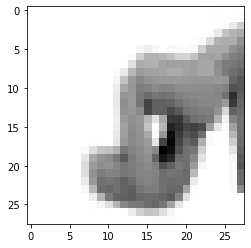

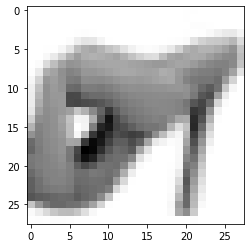

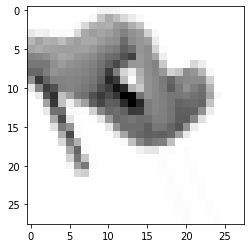

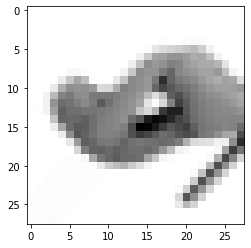

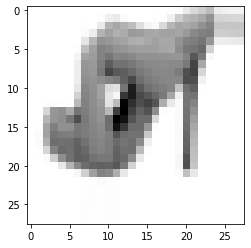

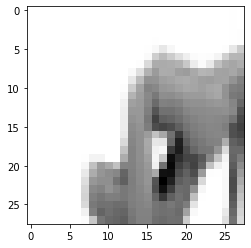

In [133]:
from keras.preprocessing import image

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory (this directory must exist)
i = 0
        
for batch in datagen.flow(shoe_augm, batch_size=1,
                          save_to_dir='preview', save_prefix='shoe', save_format='jpeg'):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]), cmap=plt.cm.binary)
    i += 1
    if i % 6 == 0:
        break # otherwise the generator would loop indefinitely

plt.show()